In [50]:
%load_ext autoreload
%autoreload 2
from MVC_env import MVC_environement
from DQN_network import embedding_network
import numpy as np
import networkx as nx
import math
import torch
from tqdm import tqdm_notebook as tqdm
import pickle

def pickle_save(data,file_name):
    with open(file_name,'wb') as f:
        pickle.dump(data , f)
def pickle_load(file_name):
    with open(file_name,'rb') as f:
        return pickle.load(f)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
from collections import namedtuple

experience = namedtuple("experience" , ['graph','Xv','action','reward','next_Xv','is_done'])

class replay_buffer():
    def __init__(self , max_size):
        self.buffer = np.zeros(  [max_size],dtype = experience)
        self.max_size = max_size
        self.size = 0
        self.idx = -1
    def push(self , new_exp):
        if(self.size >= self.max_size):
            self.idx = (self.idx+1) % self.max_size
        else:
            self.idx = self.idx + 1
            self.size += 1
        
        self.buffer[self.idx] = new_exp
    
    def sample(self , batch_size):
        batch = np.random.choice(np.arange(self.size) , size = batch_size , replace=False)
        
        return self.buffer[[batch]]
    


In [3]:
def approximate_algo(env):
    edge_list = env.edges[:]
    
    C =  set()
    #print(len(edge_list))
    while( len(edge_list) > 0):
        #print(len(edge_list))
        e = edge_list[-1]
        u,v = e
        C.add(u)
        C.add(v)
        to_remove = []
        for ed in edge_list:
            if (u in ed) or (v in ed):
                to_remove.append(ed)
        for ed in to_remove:
            edge_list.remove(ed)
    
    for v in C:
        env.take_action(v)
    
    return C
    
    
g = nx.erdos_renyi_graph(n = 200 , p = 0.15)
#g = nx.barabasi_albert_graph(n=100,m=10)
env = MVC_environement(g)
C = approximate_algo(env)
len(C)

194

In [173]:
graph_size = 50
validation_graph = []
for i in range(50):
    #p = np.random.uniform(0.05,0.)
    g = nx.erdos_renyi_graph(n = graph_size , p = 0.15)
    #g = nx.barabasi_albert_graph()
    validation_graph.append(g)
validation_graph_another = []
for i in range(50):
    #p = np.random.uniform(0.05,0.)
    g = nx.barabasi_albert_graph(graph_size , 12)
    #g = nx.erdos_renyi_graph(n = graph_size , p = 0.35)
    validation_graph_another.append(g)

In [76]:
validation_graph_ba = []
for i in range(50):
    #p = np.random.uniform(0.05,0.)
    #g = nx.erdos_renyi_graph(n = 20 , p = 0.15)
    g = nx.barabasi_albert_graph(graph_size , 4)
    validation_graph_ba.append(g)

In [174]:
nx.density(validation_graph[0]),nx.density(validation_graph_another[0])

(0.14857142857142858, 0.3722448979591837)

In [175]:
res = []
for g in validation_graph:
    env = MVC_environement(g)
    C = approximate_algo(env)
    res.append(len(C))
approx_val = sum(res)/len(res)

In [176]:
res = []
for g in validation_graph_another:
    env = MVC_environement(g)
    C = approximate_algo(env)
    res.append(len(C))
approx_val_another = sum(res)/len(res)
approx_val,approx_val_another

(45.32, 38.0)

In [69]:
def validation(dqn , validation_graph):
    objective_vals = []
    for g in validation_graph:
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        graph = torch.unsqueeze(graph,  0)
        Xv = Xv.clone()
        Xv = Xv.cuda()
        graph = graph.cuda()
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        while done == False:
            Xv = Xv.cuda()
            val = dqn(graph , Xv)[0]
            val[selected] = -999999
            action = int(torch.argmax(val).item())
            Xv_next , reward , done = env.take_action(action)
            Xv_next = Xv_next.clone()
            non_selected.remove(action)
            selected.append(action)
            Xv = Xv_next
        objective_vals.append(len(selected))
    return sum(objective_vals)/len(objective_vals)

In [ ]:
def training_validation():
    MAX_EPISODE = 501
    dqn = embedding_network(emb_dim=64 , T = 5).double()
    target_net = embedding_network(emb_dim=64 , T = 5).double()
    target_net.load_state_dict(dqn.state_dict())
    EPS_START = 1.00
    EPS_END = 0.05
    EPS_DECAY = 10000
    steps_done = 0
    loss_func = torch.nn.MSELoss()
    USE_CUDA = torch.cuda.is_available()
    N_STEP = 5
    reward_history = []
    batch_size = 128
    buffer = replay_buffer(10000)
    optimizer = torch.optim.Adam(dqn.parameters(),lr=0.00004)
    validation_result = []
    another_result = []

    if USE_CUDA:
        dqn = dqn.cuda()
        target_net = target_net.cuda()



    for e in tqdm(range(MAX_EPISODE)):

        #p = np.random.uniform(0.05,0.3)
        p = 0.15
        g = nx.erdos_renyi_graph(n = graph_size , p = p)
        #g = validation_graph[e%len(validation_graph)]
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        Xv = Xv.clone()
        graph = torch.unsqueeze(graph,  0)
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []

        if USE_CUDA:
            graph = graph.cuda()
            Xv = Xv.cuda()
        N = 0
        reward_list = []
        cur_episode_loss = []
        while done == False:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)

            if USE_CUDA:
                Xv = Xv.cuda()

            if np.random.uniform() > eps_threshold:
                val = dqn(graph , Xv)[0]
                #print(val)
                #break
                val[selected] = -99999999
                action = int(torch.argmax(val).item())
            else:
                action = int(np.random.choice(non_selected))

            Xv_next , reward , done = env.take_action(action)
            Xv_next = Xv_next.clone()
            non_selected.remove(action)
            selected.append(action)
            N += 1 
            reward_list.append(reward)
            if N >= N_STEP:
                #eward_n = sum(reward_list)
                reward_n = reward
                ex = experience(graph , Xv , torch.tensor([action]) , torch.tensor([reward_n]) , Xv_next , done)
                buffer.push(ex)
                reward_list.pop(0)
            Xv = Xv_next

            steps_done += 1

            if buffer.size >= batch_size:
                batch = buffer.sample(batch_size)
                batch = experience(*zip(*batch))
                batch_graph = torch.cat(batch.graph)
                batch_state = torch.cat(batch.Xv)
                batch_action = torch.cat(batch.action)
                batch_reward = torch.cat(batch.reward).double()
                batch_next_state = torch.cat(batch.next_Xv)
                non_final_mask = torch.tensor(tuple(map(lambda s : s is not True, batch.is_done)),dtype = torch.uint8)

                non_final_graph = batch_graph[non_final_mask]
                non_final_next_state = batch_next_state[non_final_mask]

                next_state_value = torch.zeros(batch_size).detach().double()
                if USE_CUDA:
                    batch_graph = batch_graph.cuda()
                    batch_state = batch_state.cuda()
                    batch_action = batch_action.cuda()
                    batch_reward = batch_reward.cuda()
                    batch_next_state = batch_next_state.cuda()
                    next_state_value = next_state_value.cuda()
                    non_final_graph = non_final_graph.cuda()
                    non_final_next_state = non_final_next_state.cuda()

                pred_q = dqn(batch_graph , batch_state ).gather(1 , batch_action.view(-1,1)).view(-1)


                next_state_value[non_final_mask] = target_net(non_final_graph , non_final_next_state).max(1)[0].detach()
                expected_q = next_state_value + batch_reward
                loss = loss_func(pred_q , expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                cur_episode_loss.append(loss.item())
        if len(cur_episode_loss) and e % 10 == 0:
            print(sum(cur_episode_loss)/len(cur_episode_loss) , eps_threshold)
        if e > 0 and e % 5 == 0:
            target_net.load_state_dict(dqn.state_dict())
        if e % 50 == 0:
            v = validation(dqn , validation_graph)
            validation_result.append(v)
            v = validation(dqn , validation_graph_another)
            another_result.append(v)

In [177]:
MAX_EPISODE = 501
dqn = embedding_network(emb_dim=64 , T = 5).double()
target_net = embedding_network(emb_dim=64 , T = 5).double()
target_net.load_state_dict(dqn.state_dict())
EPS_START = 1.00
EPS_END = 0.05
EPS_DECAY = 10000
steps_done = 0
loss_func = torch.nn.MSELoss()
USE_CUDA = torch.cuda.is_available()
N_STEP = 5
reward_history = []
batch_size = 128
buffer = replay_buffer(10000)
optimizer = torch.optim.Adam(dqn.parameters(),lr=0.00004)
validation_result = []
another_result = []

if USE_CUDA:
    dqn = dqn.cuda()
    target_net = target_net.cuda()



for e in tqdm(range(MAX_EPISODE)):

    #p = np.random.uniform(0.05,0.3)
    p = 0.15
    g = nx.erdos_renyi_graph(n = graph_size , p = p)
    #g = validation_graph[e%len(validation_graph)]
    env = MVC_environement(g)
    Xv , graph = env.reset_env()
    Xv = Xv.clone()
    graph = torch.unsqueeze(graph,  0)
    done = False
    non_selected = list(np.arange(env.num_nodes))
    selected = []
    
    if USE_CUDA:
        graph = graph.cuda()
        Xv = Xv.cuda()
    N = 0
    reward_list = []
    cur_episode_loss = []
    while done == False:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        
        if USE_CUDA:
            Xv = Xv.cuda()
        
        if np.random.uniform() > eps_threshold:
            val = dqn(graph , Xv)[0]
            #print(val)
            #break
            val[selected] = -99999999
            action = int(torch.argmax(val).item())
        else:
            action = int(np.random.choice(non_selected))
            
        Xv_next , reward , done = env.take_action(action)
        Xv_next = Xv_next.clone()
        non_selected.remove(action)
        selected.append(action)
        N += 1 
        reward_list.append(reward)
        if N >= N_STEP:
            #eward_n = sum(reward_list)
            reward_n = reward
            ex = experience(graph , Xv , torch.tensor([action]) , torch.tensor([reward_n]) , Xv_next , done)
            buffer.push(ex)
            reward_list.pop(0)
        Xv = Xv_next
        
        steps_done += 1
        
        if buffer.size >= batch_size:
            batch = buffer.sample(batch_size)
            batch = experience(*zip(*batch))
            batch_graph = torch.cat(batch.graph)
            batch_state = torch.cat(batch.Xv)
            batch_action = torch.cat(batch.action)
            batch_reward = torch.cat(batch.reward).double()
            batch_next_state = torch.cat(batch.next_Xv)
            non_final_mask = torch.tensor(tuple(map(lambda s : s is not True, batch.is_done)),dtype = torch.uint8)
            
            non_final_graph = batch_graph[non_final_mask]
            non_final_next_state = batch_next_state[non_final_mask]
            
            next_state_value = torch.zeros(batch_size).detach().double()
            if USE_CUDA:
                batch_graph = batch_graph.cuda()
                batch_state = batch_state.cuda()
                batch_action = batch_action.cuda()
                batch_reward = batch_reward.cuda()
                batch_next_state = batch_next_state.cuda()
                next_state_value = next_state_value.cuda()
                non_final_graph = non_final_graph.cuda()
                non_final_next_state = non_final_next_state.cuda()
                
            pred_q = dqn(batch_graph , batch_state ).gather(1 , batch_action.view(-1,1)).view(-1)
            
            
            next_state_value[non_final_mask] = target_net(non_final_graph , non_final_next_state).max(1)[0].detach()
            expected_q = next_state_value + batch_reward
            loss = loss_func(pred_q , expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cur_episode_loss.append(loss.item())
    if len(cur_episode_loss) and e % 10 == 0:
        print(sum(cur_episode_loss)/len(cur_episode_loss) , eps_threshold)
    if e > 0 and e % 5 == 0:
        target_net.load_state_dict(dqn.state_dict())
    if e % 50 == 0:
        v = validation(dqn , validation_graph)
        validation_result.append(v)
        v = validation(dqn , validation_graph_another)
        another_result.append(v)

C:\Users\Nacujachu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


0.0500264832410939 0.9517722417675569
0.24775503645361563 0.9095955471341616
0.3488218841166583 0.869145713668203
0.5824357622466914 0.8314584524483358
0.907805698323342 0.7953560208707949
1.00246890372762 0.7604950528465283
1.0060657747002695 0.7278743759711773
0.9083701552161492 0.6968160776373286
0.8167496193816152 0.6671190682326102
0.41432251018133276 0.6391978199676338
0.32445784616013884 0.6128774800174319
0.18329658616340774 0.5877329086658514
0.1157333470826247 0.5638657191809305
0.10726731158024598 0.540665181898761
0.09046567636536747 0.5188870859680393
0.10015644734335662 0.49843421126405735
0.10269596029061157 0.4784019903600169
0.1037202458705601 0.4595512239964641
0.10157229655535753 0.4411777203994085
0.11779061744037865 0.42415194486227886
0.1139917700912403 0.40718790383836484
0.08917931180481291 0.3913341756300929
0.12447484382054361 0.37611888232341095
0.13279147960575027 0.36139493206686596
0.1100985426557586 0.34778209214030087
0.17012745092455203 0.33467893022111

In [22]:
torch.tensor(tuple(map(lambda s : s is not False, batch.is_done)),dtype = torch.uint8)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.uint8)

In [202]:
#torch.save(dqn.state_dict(), 'trained_model/MVC_ER_n{}.pkl'.format(graph_size))
#pickle_save(validation_result , 'validation_result/MVC_ER_n{}_ER.pkl'.format(graph_size))
#pickle_save(ba_result , 'validation_result/MVC_ER_n{}_BA.pkl'.format(graph_size))

Text(0.5,1,'Train on ER, test on ER')

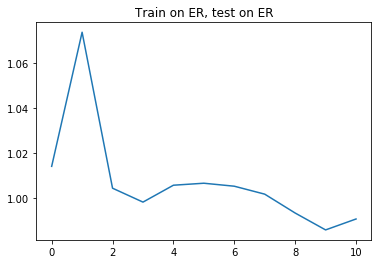

In [183]:
import matplotlib.pyplot as plt
vv = []
for v in validation_result:
    vv.append(v/approx_val)
plt.plot(vv)
plt.title('Train on ER, test on ER')

Text(0.5,1,'Train on ER, test on another')

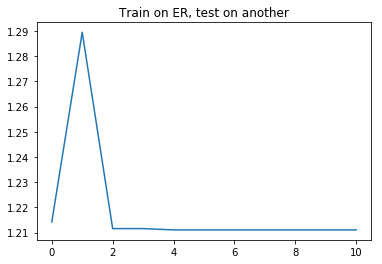

In [182]:
import matplotlib.pyplot as plt
vv_another = []
for v in another_result:
    vv_another.append(v/approx_val_another)
plt.plot(vv_another)
plt.title('Train on ER, test on another')